## Advanced Machine Learning Final Project
### Group 2
* Jake Machulcz
* Danielle Stealy
* Bridget Liesman
* Erich Haley

In [2]:
# Import pulled from most recent HW
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from wordcloud import WordCloud
import re
import random
from sklearn.metrics import (
    confusion_matrix, 
    recall_score, 
    precision_score, 
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, \
  Embedding, TextVectorization, Dropout, Input, GRU
from tensorflow.keras.callbacks import EarlyStopping

#Included to get rid of tensorflow info logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

SEED = 1842

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.utils.set_random_seed(1)

tf.config.experimental.enable_op_determinism()

## Problem Definition

Our team works under Brian Naughton, the dual CEO and head of Data Science, at _Everything at Once_, the explosive app that is used by top execs and business school students alike. This app distills the news into brief, digestable snippets, alowing busy professionals to quickly understand the day's events without spending hours pouring over newspapers. The app launched in the summer and is already on both Apple and Samsung's top 10 most downloaded apps of 2025.

Now the team is moving to the next phase and plans to provide filtering by topic to our customers to provide even more personalized news articles. This is a new feature and we are a small team so we want to focus on the biggest impact first. Through market study, we have found that our largest user demographics are business executives and university researchers. Therefore, our first round of modeling will classify articles focusing on Business vs. those focusing on Science/Technology. If we can convince Brian of our models' abilities, we can release the feature to the public and dedicate resources toward classifying other categories of interest for our users.

For our analysis, we will focus on optimizing accuracy. The main reason for this is that we do not have an obviously positive or negative outcome. Misclassifying business articles is not significantly better or worse than misclassifying science articles. If our EDA shows high class imbalance, we may consider a metric like an F1 value, but currently, we plan to focus on accuracy.

## Load and Clean the Data

In [3]:
# Code provided by project description to obtain dataset

import tensorflow_datasets as tfds
train_data, test_data = tfds.load(
  'ag_news_subset',
  split = ['train', 'test'],
  batch_size = -1,
  as_supervised=True #Added this line to ensure the code worked
)

# Split the text and labels apart
train_reviews, train_labels = tfds.as_numpy(train_data)
test_reviews, test_labels = tfds.as_numpy(test_data)

In [4]:
# Clean a single text string
def clean_text_string(s: str) -> str:
    # Replace HTML-like artifacts (#39; -> ')
    s = s.replace("#39;", "'")
    
    # Lowercase
    s = s.lower()
    
    # Keep letters, numbers, punctuation (. ? ! ')
    s = re.sub(r"[^a-z0-9.?!' ]+", " ", s)
    
    # Strip leading/trailing apostrophes
    s = s.strip("'")
    
    # Fix possessives: " john 's " -> "john's"
    s = re.sub(r"\s+'", "'", s)
    
    return s

# Clean an array of byte strings or normal strings
def clean_text_array(arr):
    cleaned = []
    for t in arr:
        # If bytes, decode to string
        if isinstance(t, bytes):
            t = t.decode("utf-8", errors="ignore")
        cleaned.append(clean_text_string(t))
    return np.array(cleaned, dtype=object)

train_reviews_clean = clean_text_array(train_reviews)
test_reviews_clean  = clean_text_array(test_reviews)

print(train_reviews_clean[:3])
print(test_reviews_clean[:3])

train_reviews_clean = clean_text_array(train_reviews)
test_reviews_clean  = clean_text_array(test_reviews)

["amd's new dual core opteron chip is designed mainly for corporate computing applications  including databases  web services  and financial transactions."
 'reuters   major league baseball monday announced a decision on the appeal filed by chicago cubs pitcher kerry wood regarding a suspension stemming from an incident earlier this season.'
 "president bush's  quot revenue neutral quot  tax reform needs losers to balance its winners  and people claiming the federal deduction for state and local taxes may be in administration planners' sights  news reports say."]
[' charlotte  n.c.  sports network    carolina panthers  running back stephen davis will miss the remainder of the  season after being placed on injured reserve saturday.'
 ' presentacion  philippines  reuters    philippine communist  rebels freed wednesday two soldiers they had held as  prisoners  of war  for more than five months  saying they wanted to  rebuild confidence in peace talks with the government.'
 "san francisco 

In [5]:
# Filtering our dataset to only include the Categories we decide to pursue.
Business = 2
SciTech  = 3

mask_train = np.isin(train_labels, [Business, SciTech])
mask_test  = np.isin(test_labels,  [Business, SciTech])


x_train_filtered = train_reviews_clean[mask_train]
y_train_filtered = train_labels[mask_train]


x_test_filtered  = test_reviews_clean[mask_test]
y_test_filtered  = test_labels[mask_test]

In [6]:
# Converting our labels to binary

label_map = {Business: 0, SciTech: 1}

y_train_bin = np.vectorize(label_map.get)(y_train_filtered)
y_test_bin  = np.vectorize(label_map.get)(y_test_filtered)

print("Unique training labels:", np.unique(y_train_bin))
print("Unique test labels:", np.unique(y_test_bin))

Unique training labels: [0 1]
Unique test labels: [0 1]


In [7]:
# Creating our Train/Validation Split
x_train, x_valid, y_train, y_valid = \
    train_test_split(x_train_filtered,  y_train_bin, test_size=0.3, stratify=y_train_bin, random_state=SEED)

#Final train, validation, and test set sizes
print('Text (train):', x_train.shape)
print('Text (validation):', x_valid.shape)
print('Text (test):', x_test_filtered.shape)
print('Labels (train):', y_train.shape)
print('Labels (validation):', y_valid.shape)
print('Labels (test):', y_test_filtered.shape)

Text (train): (42000,)
Text (validation): (18000,)
Text (test): (3800,)
Labels (train): (42000,)
Labels (validation): (18000,)
Labels (test): (3800,)


## EDA

In this section, we perform Exploratory Data Analysis (EDA) on the filtered AG News dataset to understand the characteristics of our categories of interest. We have already done some initial cleaning to focus on our categories of interest: 
* Business (label = 0)
* Sci/Tech (label = 1)

Additionally, per data science best-practices, our dataset has been split into testing and training sets and we will focus our EDA on the training set to avoid data leakage. 

### Class Balance

In order to ensure we do not have a majority class that dominates our models' predictions, we need to ensure there is balance in the two classes.

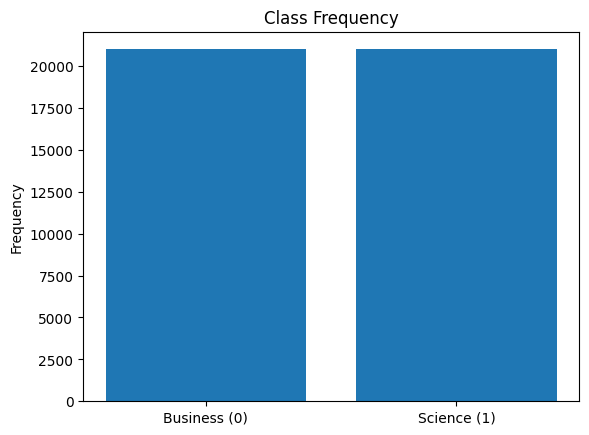

Business Count: 21000
Science Count: 21000


In [8]:
#Find counts for each class
n_bus = len(y_train) - sum(y_train)
n_sci = sum(y_train)

#Plot the counts of each class
plt.bar(['Business (0)', 'Science (1)'], [n_bus, n_sci])
plt.ylabel('Frequency')
plt.title('Class Frequency')
plt.show()

print('Business Count:', n_bus)
print('Science Count:', n_sci)

The classes are perfectly balanced in the training data, therefore we do not need to perform any over or undersampling.

### Vocabulary Analysis

In this section, we will determine how many words compose our corpus to help with setting a plausible max_token_size.

In [9]:
all_words = " ".join(x_train).split()
vocab_size = len(set(all_words))
print(vocab_size)

47930


We have a corpus of just under 50,000 words. Therefore we will want to set a max_token_size around 20,000 to ensure we have captured all the frequently used words.

### Text Length

This section will explore the distribution of the word counts for the text observations across the whole dataset as well as for each class to determine if there are any significant differences.

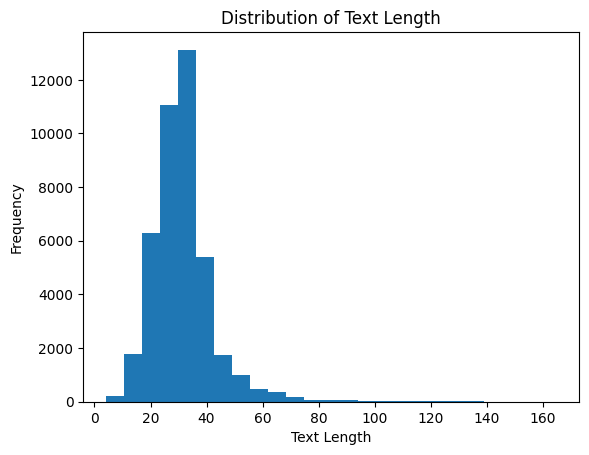

Average Length: 31.54
Median Length: 30.0
Max Length: 165
Min Length: 4
95th Percentile Length: 51.0


In [10]:
#get word counts
text_l = [len(x.split()) for x in x_train]

#plot the distribution
plt.hist(text_l, bins=25)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.show()

#print word count stats
print('Average Length:', round(np.mean(text_l),2))
print('Median Length:', np.median(text_l))
print('Max Length:', np.max(text_l))
print('Min Length:', np.min(text_l))
print('95th Percentile Length:', np.percentile(text_l, 95))

The text observations tend to be around 30 words long with a handful of longer observations. Our longest text observation is 165 words, with most words falling below 100, which means that our output_sequence_length does not need to exceed 100 and, in fact, could be around 45 and still cover 95% of the dataset. Next, let's see if there is any difference when exploring the distributions for each class.

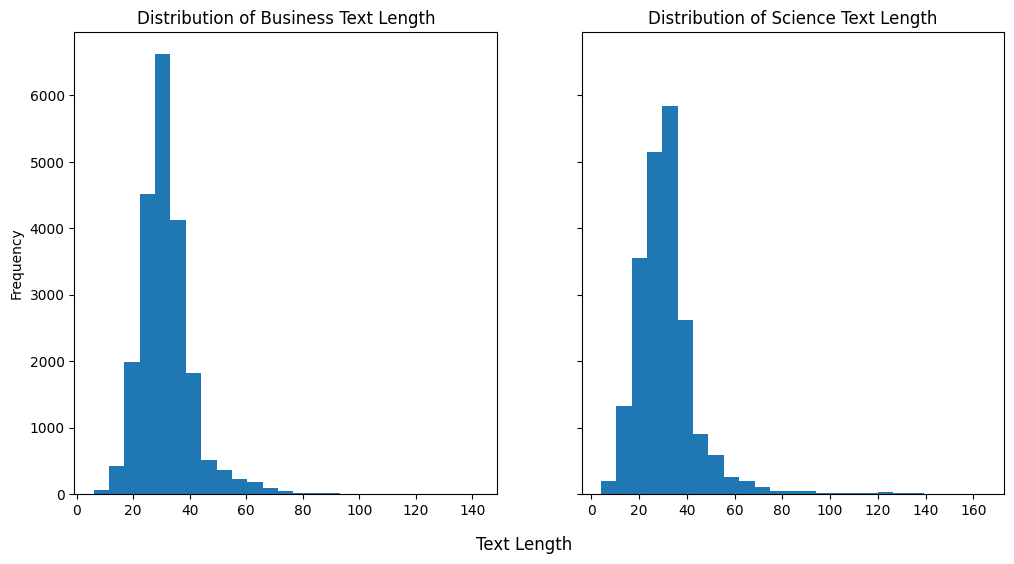

Business Average Length: 31.68
Business Median Length: 31.0
Business Max Length: 142
Business Min Length: 6


Science Average Length: 31.39
Science Median Length: 30.0
Science Max Length: 165
Science Min Length: 4


In [11]:
#get the text for each class
bus_text = x_train[y_train==0]
sci_text = x_train[y_train==1]

#get word counts
bus_text_l = [len(b.split()) for b in bus_text]
sci_text_l = [len(s.split()) for s in sci_text]

#plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].hist(bus_text_l, bins=25)
axes[0].set_title('Distribution of Business Text Length')
axes[0].set_ylabel('Frequency')
axes[1].hist(sci_text_l, bins=25)
axes[1].set_title('Distribution of Science Text Length')
fig.supxlabel('Text Length')

plt.show()

#print word count stats
print('Business Average Length:', round(np.mean(bus_text_l),2))
print('Business Median Length:', np.median(bus_text_l))
print('Business Max Length:', np.max(bus_text_l))
print('Business Min Length:', np.min(bus_text_l))
print('\n')
print('Science Average Length:', round(np.mean(sci_text_l),2))
print('Science Median Length:', np.median(sci_text_l))
print('Science Max Length:', np.max(sci_text_l))
print('Science Min Length:', np.min(sci_text_l))

Both classes tend to have texts of around 30 words in length. The Science texts have a longer right tail, showing that there are a handful of texts that skew longer, however generally, the distribution of the two classes' text lengths are similar

### Commonly Used Phrases

This section will focus on the commonly used phrases for each class to help us to better understand the makeup of the text observations for each data type.

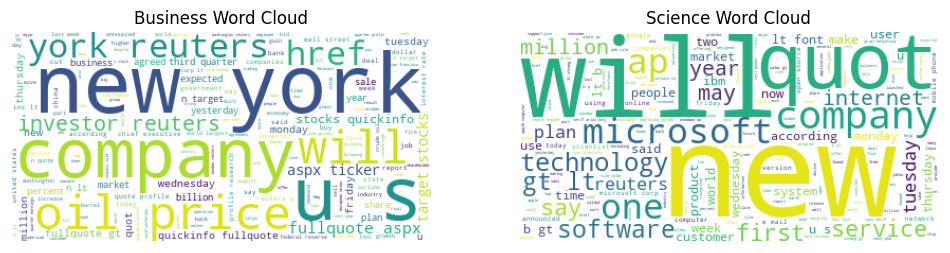

In [12]:
bus_text = " ".join(x_train[y_train == 0])
sci_text = " ".join(x_train[y_train == 1])

wc_bus = WordCloud(background_color="white").generate(bus_text)
wc_sci = WordCloud(background_color="white").generate(sci_text)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc_bus); axes[0].axis("off"); axes[0].set_title("Business Word Cloud")
axes[1].imshow(wc_sci); axes[1].axis("off"); axes[1].set_title("Science Word Cloud")
plt.show()


The above wordcloud are the most commonly used words for the whole corpus, let's now explore the most commonly used words for each class.

Based on these word clouds, we can see some differences between the two classes, however there also is some noise, such as words like 'quot' and 'FullQuote' that come from the text settings, as well as words like the city and day of the week that tell us little about the actual topic. To filter these out, we will create word clouds using the TF-IDF values instead of the word frequencies.

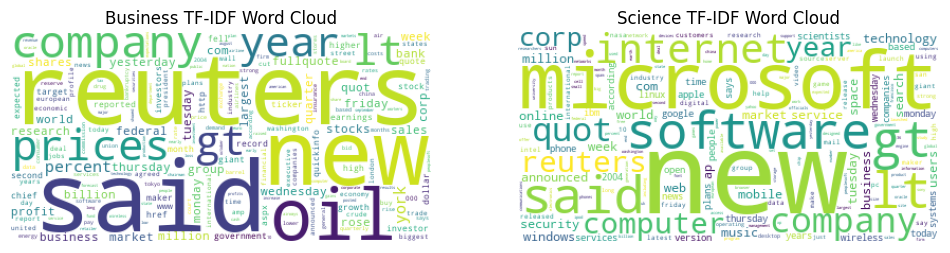

In [13]:
# Use the individual documents, not the giant joined string
bus_docs = x_train[y_train == 0]
sci_docs = x_train[y_train == 1]

# Create vectorizers
vectorizer_b = TfidfVectorizer(stop_words='english')
vectorizer_s = TfidfVectorizer(stop_words='english')

# Fit on the class-specific documents
tfidf_vals_b = vectorizer_b.fit_transform(bus_docs)
tfidf_vals_s = vectorizer_s.fit_transform(sci_docs)

# Extract vocabulary
words_b = vectorizer_b.get_feature_names_out()
words_s = vectorizer_s.get_feature_names_out()

# Average tfidf across all docs in the class
avg_tfidf_b = np.asarray(tfidf_vals_b.mean(axis=0)).flatten()
avg_tfidf_s = np.asarray(tfidf_vals_s.mean(axis=0)).flatten()

# Convert to dict for WordCloud
tfidf_b = dict(zip(words_b, avg_tfidf_b))
tfidf_s = dict(zip(words_s, avg_tfidf_s))

# Create word clouds
wc_b2 = WordCloud(background_color="white").generate_from_frequencies(tfidf_b)
wc_s2 = WordCloud(background_color="white").generate_from_frequencies(tfidf_s)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc_b2); axes[0].axis("off"); axes[0].set_title("Business TF-IDF Word Cloud")
axes[1].imshow(wc_s2); axes[1].axis("off"); axes[1].set_title("Science TF-IDF Word Cloud")
plt.show()


# This section (#4) - we should discuss

## 4. Example of News Articles

In [14]:
def show_examples(x, y, label_name, n=3):
    idx = np.where(y == label_name)[0]
    sample_idx = np.random.choice(idx, n, replace=False)

    for i in sample_idx:
        print(f"\n--- Example (Label={label_name}) ---")
        print(x[i])

show_examples(x_train, y_train, 0)  # Business
show_examples(x_train, y_train, 1)  # Sci/Tech


--- Example (Label=0) ---
the international monetary fund expects israel's economy to grow 3.6 percent by the end of this year  and 3.5 in 2005  according to the world economic outlook review released last week during succoth.

--- Example (Label=0) ---
the figures were not stuart rose's fault  but if ever there was an occasion for a little humility  this was surely it. instead  the new chief executive of marks  amp  spencer gave us his brian clough moment.

--- Example (Label=0) ---
chicago  cbs.mw    the dollar moved higher monday in the wake of little new policy direction from a weekend meeting of finance ministers and central bankers from the world's economic powers.

--- Example (Label=1) ---
 san francisco  reuters    ibm  lt a href http www.reuters.co.uk financequotelookup.jhtml?ticker ibm.n qtype sym infotype info qcat news gt ibm.n lt a gt  on friday will take  aim at the heart of data storage equipment leader emc corp.'s   lt a href http www.reuters.co.uk financequotelookup.

### EDA Summary

The EDA section explored the dataset as a whole, as well as split between the two classes. We found that the two classes are balanced and that they tend to have similar distributions of word lengths. This means that we do not need to perform any further data cleaning to ensure there is no minority/majority classes. Additionally, our models should not be skewed from differences in the structure of the text values. 

One interesting take away from the EDA section is that, despite splitting between the texts between Business and Science, actual business names dominate the word frequencies, with Reuters and Microsoft showing up with top TF-IDF values in Business and Science respectively. This may pose some difficulty in our models as text statements may focus on Science/Technology, but have business perspective.

The EDA also helped to provide starting values for our max_tokens and output_sequence_length. Since the corpus is comprised of around 82,000 words, we can initially set our max_tokens to be around 50,000 to account for the majority of frequently used words. Our text lengths are all below 165 words, with 95% of observations falling below 45 words, therefore we can initially set our output_sequence_length to be around 50. These values may change as we test and refine the models, but are helpful baseline values.

Our data exploration also revealed the types of models we should use. Our sequences range from 3 to 163 tokens with the great majority of data falling below the 50 token length, therefore they are not too long for RNN models. They could be a bit short for LSTM and GRU, however our trainig dataset has over 40,000 observations with a corpus of around 82,000 words, which is better handled by LSTM and GRU. Additionally, these text observations can include important information anywhere in the sequence and therefore LSTM and GRU may be helpful for parsing meaning across the entire the text observation. 

## Model the Data

### Baseline Model (Classical ML)

In [15]:
print(type(x_train[0]), x_train[0][:80]) 


baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=55))
])


baseline_clf.fit(x_train, y_train)


y_test_pred  = baseline_clf.predict(x_test_filtered)
y_test_proba = baseline_clf.predict_proba(x_test_filtered)[:, 1]

acc = accuracy_score(y_test_bin, y_test_pred)
conf_mat = confusion_matrix(y_test_bin, y_test_pred, labels=[0, 1])
tn, fp, fn, tp = conf_mat.ravel()
rec = recall_score(y_test_bin, y_test_pred)
prec = precision_score(y_test_bin, y_test_pred)
fpr = fp / (fp + tn)
fdr = fp / (fp + tp)
roc = roc_auc_score(y_test_bin, y_test_proba)

print("Accuracy:", round(acc, 2))
print("Confusion matrix:\n", conf_mat)
print("Recall:", round(rec, 2))
print("Precision:", round(prec, 2))
print("FPR:", round(fpr, 2))
print("FDR:", round(fdr, 2))
print("ROC AUC:", round(roc, 2))

<class 'str'> the supreme court ended monday the telemarketing industry's attempt to abolish t
Accuracy: 0.9
Confusion matrix:
 [[1689  211]
 [ 164 1736]]
Recall: 0.91
Precision: 0.89
FPR: 0.11
FDR: 0.11
ROC AUC: 0.96


In [16]:
val_acc = baseline_clf.score(x_valid, y_valid)
print("Validation Accuracy:", round(val_acc, 2))

Validation Accuracy: 0.91


We trained a baseline text classification model using a TF-IDF vectorizer (20,000 max features, bigrams included) paired with Logistic Regression.

The baseline model performed extremely well, achieving 91% validation accuracy and 90% test accuracy, with an AUC of 0.96.

The confusion matrix shows balanced performance across classes:
Business (label=0) and Sci/Tech (label=1) are both predicted with high recall (0.91) and precision (0.89).

These results indicate that the vocabulary-level differences between the two news categories are strong and largely linearly separable. As such, TF-IDF + Logistic Regression provides a robust foundation and a challenging baseline for comparison with the deep learning models (Simple RNN, LSTM, GRU).

### Deep Learning Models (RNN/LSTM/GRU)

In [17]:
#Convert the data to be usable with tensor flow functions
x_train_tf = tf.constant(x_train, dtype=tf.string)
x_valid_tf = tf.constant(x_valid, dtype=tf.string)
x_test_tf  = tf.constant(x_test_filtered, dtype=tf.string)

y_train_tf = tf.constant(y_train, dtype=tf.int32)
y_valid_tf = tf.constant(y_valid, dtype=tf.int32)
y_test_tf  = tf.constant(y_test_bin, dtype=tf.int32)

print(x_train_tf.shape, x_valid_tf.shape, x_test_tf.shape)
print(y_train_tf.shape, y_valid_tf.shape, y_test_tf.shape)

print("Train labels:", np.unique(y_train_tf.numpy()))
print("Valid labels:", np.unique(y_valid_tf.numpy()))
print("Test labels:",  np.unique(y_test_tf.numpy()))

(42000,) (18000,) (3800,)
(42000,) (18000,) (3800,)
Train labels: [0 1]
Valid labels: [0 1]
Test labels: [0 1]


In [18]:
#set parameters
max_tokens = 20000
max_sequence_length = 50
vectorized = TextVectorization(
    max_tokens=max_tokens,  
    output_sequence_length=max_sequence_length
)
vectorized.adapt(x_train_tf)

#### Simple RNN Model

In [19]:
embedding_dims = 32 
K = 16

model_rnn = Sequential()
model_rnn.add(Input(shape=(1,), dtype='string'))
model_rnn.add(vectorized)
model_rnn.add(Embedding(max_tokens + 1, embedding_dims))
model_rnn.add(SimpleRNN(K, return_sequences=False))
model_rnn.add(Dense(50, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
model_rnn.add(Dropout(.5))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 32)         │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,717 (2.45 MB)

 Trainable params: 641,717 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_rnn_history = model_rnn.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1024, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

rnn_test_loss, rnn_test_acc = model_rnn.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Test Accuracy:", rnn_test_acc)

Epoch 1/50


2025-12-02 19:12:36.429241: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7194 - loss: 0.7166 - val_accuracy: 0.8330 - val_loss: 0.5705
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8585 - loss: 0.5231 - val_accuracy: 0.8661 - val_loss: 0.4862
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9013 - loss: 0.4013 - val_accuracy: 0.8804 - val_loss: 0.4224
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9294 - loss: 0.3135 - val_accuracy: 0.8973 - val_loss: 0.3501
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9448 - loss: 0.2588 - val_accuracy: 0.8812 - val_loss: 0.3913
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9339 - loss: 0.2776 - val_accuracy: 0.8857 - val_loss: 0.3486
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9360 - loss: 0.2587 - val_accuracy: 0.8744 - val_loss: 0.3759
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9369 - loss: 0.2461 - val_accuracy: 0.8948 - val_loss: 0.

2025-12-02 19:12:51.579563: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


#### LSTM Model

In [21]:
embedding_dims = 32 
K = 16

model = Sequential()
model.add(Input(shape=(1,), dtype='string'))
model.add(vectorized)
model.add(Embedding(max_tokens + 1, embedding_dims))
model.add(LSTM(K, return_sequences=False))
model.add(Dense(50, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_history = model.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1024, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Test Accuracy:", test_acc)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 50, 32)         │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,069 (2.46 MB)

 Trainable params: 644,069 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5240 - loss: 0.8017

2025-12-02 19:12:57.382123: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5920 - loss: 0.7875 - val_accuracy: 0.8479 - val_loss: 0.6918
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8755 - loss: 0.5093 - val_accuracy: 0.8889 - val_loss: 0.4008
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9140 - loss: 0.3466 - val_accuracy: 0.9057 - val_loss: 0.3396
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9367 - loss: 0.2765 - val_accuracy: 0.9079 - val_loss: 0.3160
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9480 - loss: 0.2341 - val_accuracy: 0.9003 - val_loss: 0.3512
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9550 - loss: 0.2100 - val_accuracy: 0.8994 - val_loss: 0.3532
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9559 - loss: 0.1951 - val_accuracy: 0.8998 - val_loss: 0.3396
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9571 - loss: 0.1866 - val_accuracy: 0.9018 - val_loss: 0.

2025-12-02 19:13:15.575475: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


In [22]:
embedding_dims = 8
K = 16 

model_lstm = Sequential()
model_lstm.add(Input(shape=(1,), dtype='string'))
model_lstm.add(vectorized)
model_lstm.add(Embedding(max_tokens + 1, embedding_dims))
model_lstm.add(LSTM(K, return_sequences=False))
model_lstm.add(Dense(64, activation='relu'))
#model_lstm.add(Dropout(.5))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 50, 8)          │       160,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,761 (635.79 KB)

 Trainable params: 162,761 (635.79 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

model_lstm_history  = model_lstm.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1050, 
          validation_data=(x_valid_tf, y_valid_tf))

lstm_test_loss, lstm_test_acc = model_lstm.evaluate(x_test_tf, y_test_tf, verbose=0)
print("LSTM Test Accuracy:", lstm_test_acc)

Epoch 1/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5000 - loss: 0.6930

2025-12-02 19:13:41.008866: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5063 - loss: 0.6926 - val_accuracy: 0.5299 - val_loss: 0.6910
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7157 - loss: 0.5595 - val_accuracy: 0.8801 - val_loss: 0.3661
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9053 - loss: 0.2745 - val_accuracy: 0.9041 - val_loss: 0.2599
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9302 - loss: 0.2054 - val_accuracy: 0.9102 - val_loss: 0.2419
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9428 - loss: 0.1744 - val_accuracy: 0.9044 - val_loss: 0.2549
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9483 - loss: 0.1568 - val_accuracy: 0.8980 - val_loss: 0.2882
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9570 - loss: 0.1352 - val_accuracy: 0.9048 - val_loss: 0.2746
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9607 - loss: 0.1245 - val_accuracy: 0.9049 - val_loss: 0.

2025-12-02 19:15:08.935858: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


In [25]:
lstm_test_loss, lstm_test_acc = model_lstm.evaluate(x_test_tf, y_test_tf, verbose=0)
print("LSTM Test Accuracy:", lstm_test_acc)

LSTM Test Accuracy: 0.8705263137817383


2025-12-02 19:18:47.690747: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


#### GRU Model

In [26]:
embedding_dims = 32 

model_gru = Sequential()
model_gru.add(Input(shape=(1,), dtype='string'))
model_gru.add(vectorized)
model_gru.add(Embedding(max_tokens + 1, embedding_dims))
model_gru.add(GRU(32, return_sequences=False)) # K
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(.5))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.summary()


model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_gru.fit(x_train_tf, y_train_tf, epochs=30, batch_size=512, 
          validation_data=(x_valid_tf, y_valid_tf))

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 50, 32)         │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,545 (2.47 MB)

 Trainable params: 648,545 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2025-12-02 19:18:55.797966: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5039 - loss: 0.6932 - val_accuracy: 0.5173 - val_loss: 0.6925
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5981 - loss: 0.6303 - val_accuracy: 0.8732 - val_loss: 0.3461
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9068 - loss: 0.2590 - val_accuracy: 0.9063 - val_loss: 0.2464
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9385 - loss: 0.1827 - val_accuracy: 0.9041 - val_loss: 0.2595
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9497 - loss: 0.1554 - val_accuracy: 0.9054 - val_loss: 0.2711
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9473 - loss: 0.1606 - val_accuracy: 0.9054 - val_loss: 0.2602
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9589 - loss: 0.1273 - val_accuracy: 0.9009 - val_loss: 0.3118
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9623 - loss: 0.1167 - val_accuracy: 0.8987 - val_loss: 0.

In [27]:
gru_test_loss, gru_test_acc = model_gru.evaluate(x_test_tf, y_test_tf, verbose=0)
print("GRU Test Accuracy:", gru_test_acc)

2025-12-02 19:22:16.013589: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


GRU Test Accuracy: 0.8807894587516785


**Model Comparison & Discussion**
* Create a table to professionally report the results
    * Brief markdown discussing:
    * which model performs best
    * tradeoffs (complexity, training time, ease of deployment)
    * any overfitting / underfitting patterns you see from curves.

In [ ]:
#results = [
#    ("SVM TF-IDF", svm_valid_acc, svm_test_acc),
#    ("SimpleRNN", rnn_valid_acc, rnn_test_acc),
#    ("LSTM", lstm_valid_acc, lstm_test_acc),
#    ("GRU", gru_valid_acc, gru_test_acc),
#]

#results_df = pd.DataFrame(
#    results,
#    columns=["Model", "Validation Accuracy", "Test Accuracy"]
#)

#results_df

In [28]:
embedding_dims = 8 
K = 16

model_gru = Sequential()
model_gru.add(Input(shape=(1,), dtype='string'))
model_gru.add(vectorized)
model_gru.add(Embedding(max_tokens + 1, embedding_dims))
model_gru.add(GRU(K, return_sequences=False))
model_gru.add(Dense(50, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
model_gru.add(Dropout(.5))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 50, 8)          │       160,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 16)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,157 (633.43 KB)

 Trainable params: 162,157 (633.43 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_gru_history = model_gru.fit(x_train_tf, y_train_tf, epochs=20, batch_size=500, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

gru_test_loss, gru_test_acc = model_gru.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Test Accuracy:", gru_test_acc)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5038 - loss: 0.7809 - val_accuracy: 0.5109 - val_loss: 0.7533
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5072 - loss: 0.7330 - val_accuracy: 0.5127 - val_loss: 0.7153
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6438 - loss: 0.6216 - val_accuracy: 0.8830 - val_loss: 0.3669
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9067 - loss: 0.3048 - val_accuracy: 0.8874 - val_loss: 0.3225
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9355 - loss: 0.2325 - val_accuracy: 0.9061 - val_loss: 0.2773
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9475 - loss: 0.2025 - val_accuracy: 0.9091 - val_loss: 0.2820
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9421 - loss: 0.2070 - val_accuracy: 0.9083 - val_loss: 0.2804
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9504 - loss: 0.1828 - val_accuracy: 0.9008 - v

2025-12-02 19:22:50.910168: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


RNN Test Accuracy: 0.905526340007782
